In [1]:
#Import libraries

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import datetime as dt

In [2]:
#Import the dataset

df = pd.read_excel('ei_data_final.xlsx')

In [3]:
#Change the column name

df.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)

In [4]:
# Create dummy variables from the income level
df['treatment'] = df['salary'].apply(lambda x : 0 if x == 'low_salary' else 1).astype(int)

# Create dummy variables from the company size (categorical variable)
company_dummy = pd.get_dummies(df['company'], prefix='c_size')

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, company_dummy], axis=1)

In [5]:
# Set the data type
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m')

In [6]:
# Past-treatment dummy

policy_reform = dt.date(2020,1,1)

df['post'] = df['timestamp'].apply(lambda x : 0 if x < policy_reform else 1).astype(int)

C:\Users\hyekim\AppData\Local\Temp\ipykernel_9124\2984628181.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df['post'] = df['timestamp'].apply(lambda x : 0 if x < policy_reform else 1).astype(int)


In [7]:
# Set the Interaction dummy - Difference-in-differences term

df['interaction'] = df['treatment'] * df['post']

In [8]:
# Dummy variables for the year and month fixed effect

df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year

month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)
df = pd.concat([df, month_dummies], axis=1)

year_dummies = pd.get_dummies(df['year'], prefix='year', drop_first=True)
df = pd.concat([df, year_dummies], axis=1)

In [9]:
df.sample(10)

,timestamp,company,salary,value,treatment,c_size_large,c_size_medium,c_size_small,post,interaction,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021
1,2019-02-01,small,low_salary,596,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
135,2021-04-01,large,low_salary,184,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
20,2020-09-01,small,low_salary,735,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,0
200,2020-09-01,large,high_salary,807,1,1,0,0,1,1,...,0,0,0,0,1,0,0,0,1,0
53,2020-06-01,small,high_salary,1121,1,0,0,1,1,1,...,0,1,0,0,0,0,0,0,1,0
143,2021-12-01,large,low_salary,247,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
189,2019-10-01,large,high_salary,651,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
203,2020-12-01,large,high_salary,722,1,1,0,0,1,1,...,0,0,0,0,0,0,0,1,1,0
108,2019-01-01,large,low_salary,302,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77,2019-06-01,medium,low_salary,136,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [10]:
# set log-value
df['lnvalue'] = np.log(df['value'])

In [11]:
print(df.columns)

Index(['timestamp', 'company', 'salary', 'value', 'treatment', 'c_size_large',
       'c_size_medium', 'c_size_small', 'post', 'interaction', 'month', 'year',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'year_2020',
       'year_2021', 'lnvalue'],
      dtype='object')


In [12]:
# OLS regression on the baseline value

model_1 = smf.ols('value ~ treatment + post + interaction + c_size_large + c_size_medium', data=df).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     510.7
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          2.20e-115
Time:                        14:19:40   Log-Likelihood:                -1287.0
No. Observations:                 216   AIC:                             2586.
Df Residuals:                     210   BIC:                             2606.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       675.0787     18.277     36.935

In [13]:
# OLS regression on log values, controlling monthly seasonlity

model_2 = smf.ols('value ~ treatment + post + interaction + c_size_large + c_size_medium\
                  + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10\
                  + month_11 + month_12\
                  + year_2020 + year_2021'
                  , data=df).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     174.9
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          3.15e-109
Time:                        14:19:40   Log-Likelihood:                -1265.8
No. Observations:                 216   AIC:                             2568.
Df Residuals:                     198   BIC:                             2628.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       647.0463     26.296     24.607

In [14]:
# OLS regression on the log value

model_3 = smf.ols('lnvalue ~ treatment + post + interaction + c_size_large + c_size_medium', data=df).fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                lnvalue   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     564.0
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          1.43e-119
Time:                        14:19:40   Log-Likelihood:                 41.544
No. Observations:                 216   AIC:                            -71.09
Df Residuals:                     210   BIC:                            -50.84
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.3018      0.039    161.733

In [15]:
# OLS regression on log values, controlling monthly seasonlity

model_4 = smf.ols('lnvalue ~ treatment + post + interaction + c_size_large + c_size_medium\
                  + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10\
                  + month_11 + month_12\
                  + year_2020 + year_2021'
                  , data=df).fit()
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                lnvalue   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     177.9
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          6.58e-110
Time:                        14:19:40   Log-Likelihood:                 54.541
No. Observations:                 216   AIC:                            -73.08
Df Residuals:                     198   BIC:                            -12.33
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.2668      0.058    107.622

In [16]:
# OLS regression on log values, controlling monthly seasonlity

model_4 = smf.ols('lnvalue ~ treatment + post + interaction\
                  + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10\
                  + month_11 + month_12'
                  , data=df).fit()
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                lnvalue   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     9.447
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           6.43e-16
Time:                        14:19:40   Log-Likelihood:                -192.12
No. Observations:                 216   AIC:                             414.2
Df Residuals:                     201   BIC:                             464.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.5756      0.171     32.556      

In [17]:
# Import libraries for data visualisation

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Import additional datasets for visualisation

df_female = pd.read_excel("ei_final_female.xlsx")
total_male_df = pd.read_excel("viz_male_eidata.xlsx")

In [19]:
# Create dummy variables from the income level
df_female['treatment'] = df_female['salary'].apply(lambda x : 0 if x == 'low_salary' else 1).astype(int)

# Create dummy variables from the company size (categorical variable)
fcompany_dummy = pd.get_dummies(df_female['company'], prefix='c_size')

# Concatenate the dummy variables with the original DataFrame
df_female = pd.concat([df_female, fcompany_dummy], axis=1)

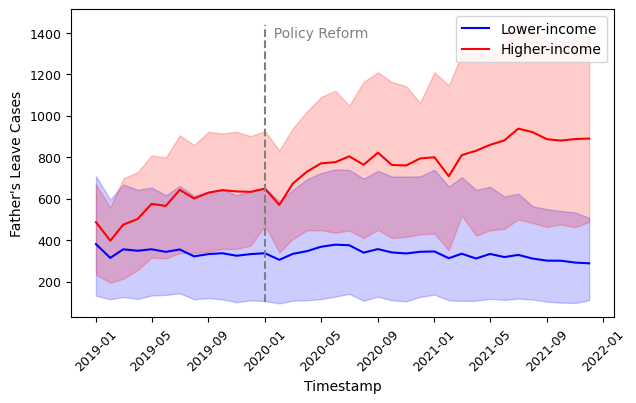

In [20]:
custom_palette = {1: 'red', 0: 'blue'}

# Create a Seaborn line plot with the custom palette
plt.figure(figsize=(7, 4))  # Adjust the figure size as needed
chart = sns.lineplot(data=df, x="timestamp", y="value", hue="treatment", palette=custom_palette)

# Add labels and rotation to x-axis ticks
plt.xlabel("Timestamp", fontsize=10)
plt.ylabel("Father's Leave Cases", fontsize=10)
plt.xticks(rotation=45)

# Add a dashed vertical line for policy reform
chart.axvline(x=policy_reform, ymin=0.05, ymax=0.95, linestyle="dashed", color='gray')

# Add a notation to the vertical line
plt.text(policy_reform, chart.get_ylim()[1] * 0.9, '  Policy Reform', color='gray', ha='left', va='bottom')

plt.xticks(fontsize=9)  
plt.yticks(fontsize=9)

# Create a custom legend
custom_legend = plt.legend(loc="best", title="")

legend_labels = {1: 'Higher-income', 0: 'Lower-income'}
for key, value in legend_labels.items():
    custom_legend.get_texts()[key].set_text(value)

# Show the plot
plt.show()

In [21]:
df_female

,timestamp,company,salary,value,treatment,c_size_large,c_size_medium,c_size_small
0,2019-01-01,small,low_salary,12063,0,0,0,1
1,2019-02-01,small,low_salary,10539,0,0,0,1
2,2019-03-01,small,low_salary,11574,0,0,0,1
3,2019-04-01,small,low_salary,11552,0,0,0,1
4,2019-05-01,small,low_salary,11533,0,0,0,1
...,...,...,...,...,...,...,...,...
211,2021-08-01,large,high_salary,3030,1,1,0,0
212,2021-09-01,large,high_salary,2751,1,1,0,0
213,2021-10-01,large,high_salary,2947,1,1,0,0
214,2021-11-01,large,high_salary,3013,1,1,0,0


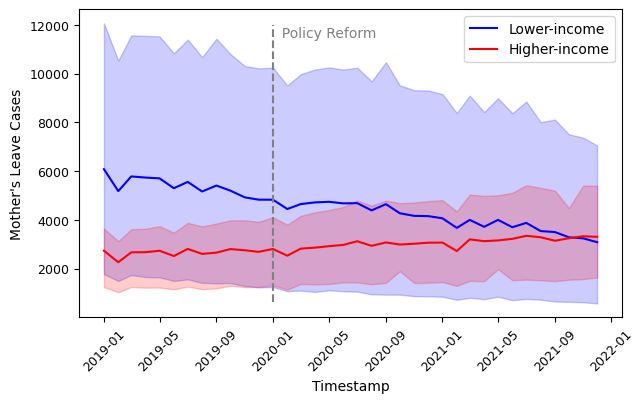

In [22]:
custom_palette = {1: 'red', 0: 'blue'}

# Create a Seaborn line plot with the custom palette
plt.figure(figsize=(7, 4))  # Adjust the figure size as needed
chart = sns.lineplot(data=df_female, x="timestamp", y="value", hue="treatment", palette=custom_palette)

# Add labels and rotation to x-axis ticks
plt.xlabel("Timestamp", fontsize=10)
plt.ylabel("Mother's Leave Cases", fontsize=10)
plt.xticks(rotation=45)

# Add a dashed vertical line for policy reform
chart.axvline(x=policy_reform, ymin=0.05, ymax=0.95, linestyle="dashed", color='gray')

# Add a notation to the vertical line
plt.text(policy_reform, chart.get_ylim()[1] * 0.9, '  Policy Reform', color='gray', ha='left', va='bottom')

plt.xticks(fontsize=9)  
plt.yticks(fontsize=9)

# Create a custom legend
custom_legend = plt.legend(loc="best", title="")

legend_labels = {1: 'Higher-income', 0: 'Lower-income'}
for key, value in legend_labels.items():
    custom_legend.get_texts()[key].set_text(value)

# Show the plot
plt.show()

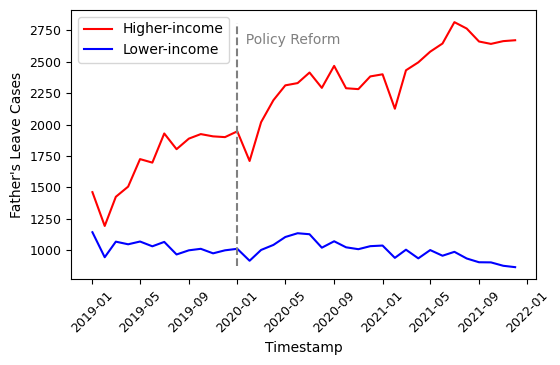

In [23]:
custom_palette = {0: 'red', 1: 'blue'}

# Create a Seaborn line plot with the custom palette
plt.figure(figsize=(6, 3.5))  # Adjust the figure size as needed
chart = sns.lineplot(data=total_male_df, x="timestamp", y="value", hue="treatment", palette=custom_palette)

# Add labels and rotation to x-axis ticks
plt.xlabel("Timestamp", fontsize=10)
plt.ylabel("Father's Leave Cases", fontsize=10)
plt.xticks(rotation=45)

# Add a dashed vertical line for policy reform
chart.axvline(x=policy_reform, ymin=0.05, ymax=0.95, linestyle="dashed", color='gray')

# Add a notation to the vertical line
plt.text(policy_reform, chart.get_ylim()[1] * 0.9, '  Policy Reform', color='gray', ha='left', va='bottom')

plt.xticks(fontsize=9)  
plt.yticks(fontsize=9)

# Create a custom legend
custom_legend = plt.legend(loc="best", title="")

legend_labels = {0: 'Higher-income', 1: 'Lower-income'}
for key, value in legend_labels.items():
    custom_legend.get_texts()[key].set_text(value)

# Show the plot
plt.show()

In [24]:
df_total_f = pd.read_excel("female_total.xlsx")

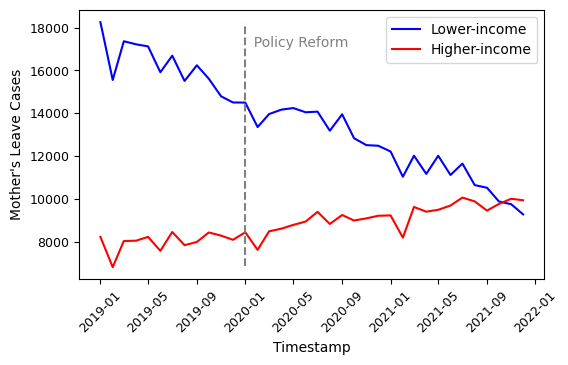

In [25]:
custom_palette = {1: 'red', 0: 'blue'}

# Create a Seaborn line plot with the custom palette
plt.figure(figsize=(6, 3.5))  # Adjust the figure size as needed
chart = sns.lineplot(data=df_total_f, x="timestamp", y="value", hue="treatment", palette=custom_palette)

# Add labels and rotation to x-axis ticks
plt.xlabel("Timestamp", fontsize=10)
plt.ylabel("Mother's Leave Cases", fontsize=10)
plt.xticks(rotation=45)

# Add a dashed vertical line for policy reform
chart.axvline(x=policy_reform, ymin=0.05, ymax=0.95, linestyle="dashed", color='gray')

# Add a notation to the vertical line
plt.text(policy_reform, chart.get_ylim()[1] * 0.9, '  Policy Reform', color='gray', ha='left', va='bottom')

plt.xticks(fontsize=9)  
plt.yticks(fontsize=9)

# Create a custom legend
custom_legend = plt.legend(loc="best", title="")

legend_labels = {1: 'Higher-income', 0: 'Lower-income'}
for key, value in legend_labels.items():
    custom_legend.get_texts()[key].set_text(value)

# Show the plot
plt.show()